In [1]:
import pandas as pd

df = pd.read_csv('steam-200k.csv', names = ['id', 'game_name', 'action', 'play_time'])


# EDA and visulazation

In [2]:
print(df.head())
print(df['game_name'].nunique())
print(df['play_time'].describe())

          id                   game_name    action  play_time
0  151603712  The Elder Scrolls V Skyrim  purchase        1.0
1  151603712  The Elder Scrolls V Skyrim      play      273.0
2  151603712                   Fallout 4  purchase        1.0
3  151603712                   Fallout 4      play       87.0
4  151603712                       Spore  purchase        1.0
5155
count    200000.000000
mean         17.874384
std         138.056952
min           0.100000
25%           1.000000
50%           1.000000
75%           1.300000
max       11754.000000
Name: play_time, dtype: float64


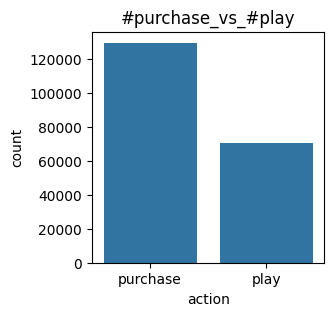

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (3,3))
sns.countplot(x = df['action'])
plt.title('#purchase_vs_#play')
plt.show()


In [4]:
# we find once the user bought the game, the play_time will automaticly be 1, and that's not the actual playing time.
# the actual playtime should match with action 'play'

actual_play_df = df[df['action'] == 'play'].copy() 

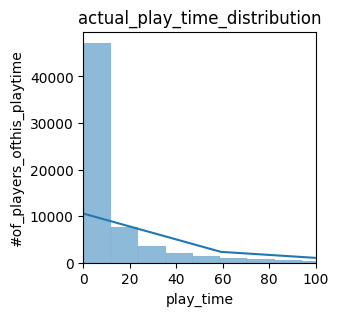

In [5]:
plt.figure(figsize = (3,3))
sns.histplot(x = actual_play_df['play_time'], bins = 1000, kde = True)
plt.xlim(0,100)
plt.ylabel('#of_players_ofthis_playtime')
plt.title('actual_play_time_distribution')
plt.show()

In [6]:
top_10_games = (
    df.groupby('game_name')['id'].nunique().sort_values(ascending = False).head(10)
)
print(top_10_games)

game_name
Dota 2                             4841
Team Fortress 2                    2323
Unturned                           1563
Counter-Strike Global Offensive    1412
Half-Life 2 Lost Coast              981
Counter-Strike Source               978
Left 4 Dead 2                       951
Counter-Strike                      856
Warframe                            847
Half-Life 2 Deathmatch              823
Name: id, dtype: int64


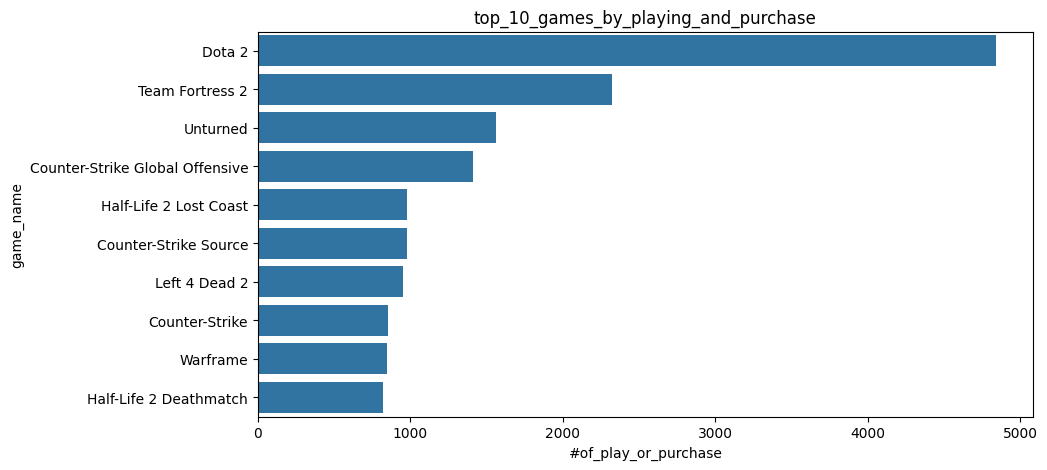

In [7]:
import numpy as np
plt.figure(figsize = (10, 5))
top_10_games = (
    df.groupby('game_name')['id'].nunique().sort_values(ascending = False).head(10)
)
sns.barplot(y=top_10_games.index, x=top_10_games.values)
plt.xlabel('#of_play_or_purchase')
plt.title('top_10_games_by_playing_and_purchase')
plt.show()

# Build implicit feedback dataframe

In [8]:
# we need to build a new features called weight that indicate the love extent of this user about this game
df_copy = df.copy()

purchase_weight = 0.2
df_copy['weight'] = np.where(df_copy['action'] == 'play', 
                            np.sqrt(df_copy['play_time']), 
                            df_copy['play_time']* purchase_weight)

df_copy = df_copy.groupby(['id','game_name'])['weight'].sum().reset_index()
# like in postgresql, a groupby funciton must be some features + one feature aggregation

df_copy.head()

,id,game_name,weight
0,5250,Alien Swarm,2.413594
1,5250,Cities Skylines,12.200000
2,5250,Counter-Strike,0.200000
3,5250,Counter-Strike Source,0.200000
4,5250,Day of Defeat,0.200000


# Cold Start filtering

In [9]:

df_copy['uses_played_games_count'] = df_copy.groupby('id')['game_name'].transform('nunique')
df_copy['games_be_played_count'] = df_copy.groupby('game_name')['id'].transform('nunique')
df_copy = df_copy[(df_copy['uses_played_games_count'] >= 1) & (df_copy['games_be_played_count'] >= 1)]
df_copy.head()

,id,game_name,weight,uses_played_games_count,games_be_played_count
0,5250,Alien Swarm,2.413594,21,289
1,5250,Cities Skylines,12.200000,21,122
2,5250,Counter-Strike,0.200000,21,856
3,5250,Counter-Strike Source,0.200000,21,978
4,5250,Day of Defeat,0.200000,21,534


# make the sprase matrix

change the id and game_name to codes

In [10]:
df_copy['user_index'], user_labels = pd.factorize(df_copy['id'])
df_copy['game_index'], game_labels = pd.factorize(df_copy['game_name'])
df_copy = df_copy.drop(columns = ['id', 'game_name', 'uses_played_games_count', 'games_be_played_count'])
df_copy

,weight,user_index,game_index
0,2.413594,0,0
1,12.200000,0,1
2,0.200000,0,2
3,0.200000,0,3
4,0.200000,0,4
...,...,...,...
128799,2.788436,12389,21
128800,0.200000,12390,326
128801,0.200000,12390,589
128802,1.036660,12391,7


# Build the ALS model

In [11]:
# ==== FINAL (ROBUST): ALS 训练（items×users 输入，强制 CSR，含自检与兜底）====
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight  # 可选

# 1) 基本索引与矩阵（users × items）
n_user = int(df_copy['user_index'].max() + 1)
n_game = int(df_copy['game_index'].max() + 1)

u = df_copy['user_index'].to_numpy(np.int32)    # 用 int32 更稳
g = df_copy['game_index'].to_numpy(np.int32)
w = df_copy['weight'].to_numpy(np.float32)

# users × items (CSR)
USER_ITEMS = coo_matrix((w, (u, g)), shape=(n_user, n_game), dtype=np.float32).tocsr()

# （可选）隐式权重，如需打开：
USER_ITEMS = bm25_weight(USER_ITEMS).tocsr()

ALPHA = 10.0

# === 关键：ALS 期望 items × users，且最好是 CSR ===
# 注意：CSR.T 会得到 CSC，因此必须再转回 CSR
ITEMS_USERS = USER_ITEMS.T.tocsr()              # 先转置再转回 CSR
ITEMS_USERS = ITEMS_USERS.multiply(ALPHA)       # 再做缩放（矩阵安全）

print("[DEBUG] USER_ITEMS shape:", USER_ITEMS.shape)     # (n_user, n_game)
print("[DEBUG] ITEMS_USERS shape:", ITEMS_USERS.shape)   # (n_game, n_user)

# 2) 训练 ALS
als_model = AlternatingLeastSquares(
    factors=64,
    regularization=0.05,
    iterations=15,
    random_state=42
)
als_model.fit(ITEMS_USERS)

# 3) 自检：确保 item_factors/user_factors 与 ITEMS_USERS 对齐
if als_model.item_factors.shape[0] != ITEMS_USERS.shape[0] or \
   als_model.user_factors.shape[0] != ITEMS_USERS.shape[1]:
    # 兜底：若库版本/稀疏格式导致方向被误判，强制用转置再训一遍
    print("[WARN] Factors shape mismatch, retry with transposed input ...")
    als_model = AlternatingLeastSquares(
        factors=64,
        regularization=0.05,
        iterations=15,
        random_state=42
    )
    als_model.fit(ITEMS_USERS.T.tocsr())  # 兜底：再用 users×items 输入尝试
    # 二次自检（若还不对就抛错）
    assert als_model.item_factors.shape[0] in (n_game, n_user), \
        f"Unexpected item_factors rows: {als_model.item_factors.shape[0]} (n_game={n_game}, n_user={n_user})"
    assert als_model.user_factors.shape[0] in (n_user, n_game), \
        f"Unexpected user_factors rows: {als_model.user_factors.shape[0]} (n_user={n_user}, n_game={n_game})"
else:
    # 正常路径：严格等于
    assert als_model.item_factors.shape[0] == n_game, \
        f"item_factors 行数应等于物品数 n_game={n_game}, 实际={als_model.item_factors.shape[0]}"
    assert als_model.user_factors.shape[0] == n_user, \
        f"user_factors 行数应等于用户数 n_user={n_user}, 实际={als_model.user_factors.shape[0]}"

# 4) 推荐阶段统一用 users×items
USER_ITEMS_FOR_RECS = USER_ITEMS

print(
    "OK:",
    "user_items", USER_ITEMS.shape,           # (n_user, n_game)
    "| items_users", ITEMS_USERS.shape,       # (n_game, n_user)
    "| item_factors", als_model.item_factors.shape,
    "| user_factors", als_model.user_factors.shape
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[DEBUG] USER_ITEMS shape: (12393, 5155)
[DEBUG] ITEMS_USERS shape: (5155, 12393)


100%|██████████| 15/15 [00:00<00:00, 20.44it/s]


[WARN] Factors shape mismatch, retry with transposed input ...


100%|██████████| 15/15 [00:00<00:00, 21.24it/s]

OK: user_items (12393, 5155) | items_users (5155, 12393) | item_factors (5155, 64) | user_factors (12393, 64)


# Deliver our top-n recommedations

In [12]:
# Deliver our top-n recommedations —— 用 factorize 后的标签来建映射
user_ids = [str(u) for u in user_labels]      # 真实用户ID，转成字符串
game_names = [str(g) for g in game_labels]    # 真实游戏名，转成字符串

# 注意：从 0 开始，对齐 train_csr 的行列索引
user2row = {u: i for i, u in enumerate(user_ids)}
row2user = {i: u for u, i in user2row.items()}

game2col = {u: i for i, u in enumerate(game_names)}
col2game = {i: u for u, i in game2col.items()}

def future_recommending():
    # 1) 用户与 top_n 输入
    user_id_input = input("please type the user_id: ").strip()
    if not user_id_input or user_id_input not in user2row:
        print("❌ user id not found in our database")
        return
    u_index = user2row[user_id_input]

    total_items = USER_ITEMS_FOR_RECS.shape[1]
    raw = input(f"how many games do you want? (1 ~ {total_items}, default 10): ").strip()
    try:
        top_n = 10 if not raw else int(raw)
    except ValueError:
        print("❌ please input an integer")
        return
    if not (1 <= top_n <= total_items):
        print(f"❌ the recommend games must be between 1 and {total_items}")
        return

    # 2) 过采样 N（考虑过滤后仍有足够候选）
    already_liked = USER_ITEMS_FOR_RECS[u_index].getnnz()
    N = min(total_items, already_liked + top_n + 2000)  # 更激进些

    # 3) 调 ALS 推荐
    # 关键：传整张 users×items 矩阵，交给 implicit 做过滤更稳
    result = als_model.recommend(
        userid=u_index,
        user_items=USER_ITEMS_FOR_RECS[u_index],     # ✅ 整张矩阵
        N=N,
        filter_already_liked_items=True,
        recalculate_user=True
    )

    # 4) 兼容不同返回格式
    # 方案A：返回 (ids_array, scores_array)
    if isinstance(result, tuple) and len(result) == 2:
        item_indices, scores = result
        item_indices = item_indices[:top_n]
        scores = scores[:top_n]
        recommended_games = [col2game[int(col)] for col in item_indices]
        scores = [float(s) for s in scores]
    else:
        # 方案B：返回 [(item_id, score), ...] 列表/ndarray
        pairs = list(result)[:top_n]
        # 每个元素兼容 array/tuple，取前两列
        item_indices = [int(p[0]) for p in pairs]
        scores = [float(p[1]) for p in pairs]
        recommended_games = [col2game[col] for col in item_indices]

    # 5) 输出
    if len(recommended_games) < top_n:
        print(f"⚠️ 仅返回 {len(recommended_games)} 条推荐结果（可能该用户覆盖太广/冷启动）。可继续增大 N 或放宽过滤。")

    print(f"\n✅ Top-{len(recommended_games)} recommendations for user {user_id_input}:")
    for i, (g, s) in enumerate(zip(recommended_games, scores), start=1):
        print(f"{i:>2}. {g} (score={s:.4f})")


In [13]:
future_recommending()



✅ Top-10 recommendations for user 5270060:
 1. Half-Life 2 (score=0.5164)
 2. DC Universe Online (score=0.3670)
 3. Half-Life Source (score=0.3262)
 4. Left 4 Dead (score=0.3257)
 5. Half-Life Deathmatch Source (score=0.3077)
 6. Grand Theft Auto IV (score=0.2946)
 7. Zombie Panic Source (score=0.2901)
 8. Alien Swarm (score=0.2748)
 9. Half-Life 2 Episode One (score=0.2615)
10. Garry's Mod (score=0.2453)
